# Read the input dataset :

1. usable_samples_ADNI.json : stores the IID (index) for each row of PRS_feature_matrix.npy
2. PRS_feature_matrix.npy : PR Score for different features
3. Covar_FILE_bigger_dataset : for reading covar such as age, gender
4. Final_Samples.json : contains ID and output for each data

In [1]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

import pandas as pd
import numpy as np
import json
import random
import math

import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable
import torch
from torch.utils import data

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE = "cpu"

import shap
from copy import deepcopy

import pickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import tpot

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

In [2]:
# !pip install skfeature-chappers
# !pip install mlxtend
# !pip --version
# !pip install imblearn
# !conda install -c conda-forge imbalanced-learn
# conda install -c conda-forge tqdm
# conda install mlxtend

# conda config --add channels conda-forge
# conda install hyperopt

# conda config --add channels conda-forge
# conda config --set channel_priority strict
# conda install auto-sklearn
# conda install -c conda-forge tpot



Show the installed packages with their versions

In [3]:
!conda list

# packages in environment at /home/bayzid/anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2020.07                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   1.0.0                    pypi_0    pypi
adjusttext                0.7.3                    pypi_0    pypi
alabaster                 0.7.13             pyhd8ed1ab_0    conda-forge
alignment-c               1.0.0                    pypi_0    pypi
anaconda                  custom                   py37_1  
anaconda-client           1.12.0             pyhd8ed1ab_0    conda-forge
anaconda-navigator        2.1.0            py37h06a4308_0  
anaconda-project          0.11.1             pyhd8ed1ab_0    conda-forge
anyio                     3.7.1              pyhd8ed1ab_0    conda-forge
ar

In [4]:
random_seed = 42 # or any of your favorite number 
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

In [5]:
yrs = 'nores'
progression = ""

Covar for ADNI Plink

# Alter parameters :
    1. Number of features
    2. Number of Hidden Layers 
    3. Dimension of Hidden Layers

In [6]:
# num_features = 52
hidden = 4
hidden_dimension = 32

In [7]:
# # take the first num_features column from PRS_feature_matrix
# PRS_feature_matrix = PRS_orig_feature_matrix
# PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
# print(PRS_feature_matrix.shape)

Final Samples has two columns of data :
    1. ID 
    2. output - true / false
    
Get the length of positive and negative samples of test dataset

In [8]:
# # positive samples - output true
# # negative samples - output false
# len_positive_samples = 0
# len_negative_samples = 0
# for x in Final_Samples:
#     if x[1] == 1 :
#         len_positive_samples += 1
#     else :
#         len_negative_samples += 1
        
# print(len(Final_Samples))
# print(len_positive_samples)
# print(len_negative_samples)

# Combining covar data with PRS Feature Matrix

In [9]:
# # cnt = number of missing IDs for which covar data doesn't exist
# cnt = 0
# print("Before adding covar_df columns, shape : ",PRS_feature_matrix.shape)
# # adding ( total columns - 2 ) of covar_df , excluding FID, IID
# FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], covar_df.shape[1] - 2 ])], 1).astype(np.float32)
# print("Before adding covar_df columns, shape : ",FEATURE_MATRIX.shape)
# for sample in usable_samples_ADNI:
#     # taking from the PCs, skipping the first two columns of IID, FID
#     covar = covar_df[covar_df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) 
#     # shape[0] = 1 means a row is found in covar for the following sample ID
#     # if not, that means no covar data exists for the sample in usable_samples_ADNI
#     if covar.shape[0] != 1:
# #         print(covar.shape)
#         print(sample)
#         cnt += 1
#         continue
#     # Adding the covar values to the feature matrix
#     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar


# print("Count of missing samples for covar data : ", cnt)
# #     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
# # cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

# Create directory for saving shap figures

In [10]:
# path = "./shap/" + str(num_features)
# if not os.path.exists(path):
#     os.makedirs(path)

# Storing the index with the Age = 0

age is zero for the rows that the covar data was not found

In [11]:
# age_zero = 0
# age_zero_idx = []
# for i in range( len(FEATURE_MATRIX) ):
#     if FEATURE_MATRIX[i, -1] == 0.00:
#         age_zero += 1
#         age_zero_idx.append(i)
        
# print(age_zero)

# Indices of features to consider

In [12]:


# # feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# # naeem modified
# print(FEATURE_MATRIX.shape[1])
# last_idx = FEATURE_MATRIX.shape[1] - 1
# feature_indices_to_consider = list(range(num_features))  + [last_idx - 1, last_idx] #list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# # remove_indices = [1, 2, 3]
# # for i in remove_indices:
# #     feature_indices_to_consider.remove(i)

# # feature_indices_to_consider = list(range(23, 36))

# # feature_indices_to_consider = [ 4, 11, 14, 21, 23, 26, 32, 34, 46]

# # feature_indices_to_consider = [ 9, 10, 11, 14, 21, 23, 26, 28, 32, 34, 46]
# # feature_indices_to_consider = [9, 10, 28, 34, 46]

# print(feature_indices_to_consider)
# # feature_indices_to_consider = [1, 2, 3, 11, 14, 21, 23, 26, 32, 45]
# # feature_indices_to_consider = [2, 26, 32, 45]


# Functions & Classes

In [13]:
# save_in_file: saves model accuracy in a text file
#     args : model_name : name of model with layers and dimensions
#            accuracy : accuracy  score
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

**Modifications**
1. Added relu in the hidden layers and sigmoid in the output layer as activation functions
2. Added dropout in the hidden layers

In [14]:
class simple_model(nn.Module):
    def __init__(self, num_features, hidden_dim= hidden_dimension, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
            # added by Mashiat
            features = self.dropout(features, p=self.drop_probab)
            features = self.relu( features )
            ####################
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [15]:
# simple_model(num_features=len(feature_indices_to_consider))

# dataSet class 
combines usable_samples_ADNI, Final_Samples, feature_matrix to one dataset with features and labels

In [16]:
# class dataSet(data.Dataset):
#     def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
#         super(dataSet, self).__init__()  
#         self.data_len = len(Final_Samples)
#         self.usable_samples_ADNI = usable_samples_ADNI
#         self.Final_Samples = Final_Samples
#         self.feature_indices_to_consider = feature_indices_to_consider
#         self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
#     def __getitem__(self, index):
#         features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
#         label = torch.tensor([float(self.Final_Samples[index][1])]).float()
#         return features, label
    
#     def update_prs_features(self, mean, std):
#         self.feature_matrix = (self.feature_matrix - mean) / std
        
#     def get_mean_std(self):
#         mean = self.feature_matrix.mean(0)
#         std = self.feature_matrix.std(0)
#         return mean, std
        
#     def __len__(self):
#         return self.data_len

# Converting Pandas Dataframe to Dataset class

overriding the constructor, getitem, len function of the original class

In [17]:
class df_dataSet(data.Dataset):
    def __init__(self, X, y):
        
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
        
        
    def __len__(self):
        return len(self.labels)

In [18]:
# # random samples : sample test dataset taking equal number of positive & negative outputs
# #                 args : 
# #                         total_folds : fold number for splitting
# #                         random_seed : seed value for randomization
# #                 return :
# #                         N_splits : test dataset splitted according to fold numbers
                        
# def random_samples(total_folds, random_seed=None):
#     Final_Samples = json.load(open(Final_Samples_path, 'r')) 
#     positive_samples = Final_Samples[:len_positive_samples]
#     negative_samples = Final_Samples[len_positive_samples:]
#     min_len = min( len(positive_samples), len(negative_samples))
#     if random_seed is not None: 
#         random.seed(random_seed * 2)
#     random.shuffle(positive_samples)
#     random.shuffle(negative_samples)
#     print("min length : ", min_len)
#     Final_Samples = positive_samples[:min_len] + negative_samples[:min_len]
#     random.shuffle(Final_Samples)
#     print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
#     Final_Samples = np.array(Final_Samples)

# #   -----------------------------------------------------------------------
# #     positive_samples = Final_Samples[:654]
# #     negative_samples = Final_Samples[654:]
# #     if random_seed is not None: 
# #         random.seed(random_seed * 2)
# #     random.shuffle(positive_samples)
# #     random.shuffle(negative_samples)
# #     Final_Samples = positive_samples[:500] + negative_samples[:500]
# #     if random_seed is not None: 
# #         random.seed(random_seed)
# #     random.shuffle(Final_Samples)
# #     Final_Samples = np.array(Final_Samples)
# # --------------------------------------------------------------------------
#     N_splits = Final_Samples.reshape(total_folds, -1, 2)
#     return N_splits

# # generate_datasets : get train, validation & test datasets
# #                 args : 
# #                         N_splits : data splitted according to folds; output of random samples
# #                         fold_num : fold_num for test dataset
# #                         random_seed : seed value for randomization
# #                 return :
# #                         train_set, test_set, val_set : datasets
# def generate_datasets(N_splits, fold_num, random_seed):
#     test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
#     train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
#     if random_seed is not None: 
#         random.seed(random_seed * 3)
#     random.shuffle(train_samples)
#     train_samples = np.array(train_samples)
#     # take all as training dataset, leaves nothing for validation - multiply shpae by 1
#     split_pos = int(train_samples.shape[0] * 1.) 
#     #split_pos = int(train_samples.shape[0] * .8) 
# #     print(train_samples.shape, split_pos, train_samples.shape[0])
#     train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
#     train_set = dataSet(Final_Samples=train_samples, 
#                         feature_matrix=FEATURE_MATRIX, 
#                         usable_samples_ADNI=usable_samples_ADNI)
#     val_set = dataSet(Final_Samples=val_samples, 
#                       feature_matrix=FEATURE_MATRIX, 
#                       usable_samples_ADNI=usable_samples_ADNI)
#     test_set = dataSet(Final_Samples=test_samples, 
#                       feature_matrix=FEATURE_MATRIX, 
#                       usable_samples_ADNI=usable_samples_ADNI)
#     mean, std = train_set.get_mean_std()
#     # normalize dataset
#     train_set.update_prs_features(mean, std)
#     val_set.update_prs_features(mean, std)
#     test_set.update_prs_features(mean, std)
# #     print(len(train_set))
# #     print(len(val_set))
# #     print(len(test_set))
#     return train_set, val_set, test_set



# # generate_loader : get train, validation & test as torch dataset
# #                 args : 
# #                         train_set, test_set, val_set : datasets
# #                 returns :
# #                         train, val & test torch datasets
# def generate_loader(train_set, val_set, test_set, num_workers):
#     train_batch_size = train_set.__len__()
#     val_batch_size = val_set.__len__()
#     test_batch_size = test_set.__len__()
#     train_loader = torch.utils.data.DataLoader(train_set,
#                                               batch_size=train_batch_size,
#                                               shuffle=True,
#                                               pin_memory=(torch.cuda.is_available()),
#                                               num_workers=num_workers)
#     val_loader = torch.utils.data.DataLoader(val_set,
#                                               batch_size=val_batch_size,
#                                               shuffle=False,
#                                               pin_memory=(torch.cuda.is_available()),
#                                               num_workers=num_workers)
#     test_loader = torch.utils.data.DataLoader(test_set,
#                                               batch_size=test_batch_size,
#                                               shuffle=False,
#                                               pin_memory=(torch.cuda.is_available()),
#                                               num_workers=num_workers)
#     return train_loader, val_loader, test_loader

# # train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
# # val_set.feature_matrix.shape

In [19]:
# epoch function : runs an epoch of a model
#                 args :
#                         model : neural network model
#                         optimizer :
#                         criterion :
#                         is_training : train - true or test - false
#                         loader : torch dataset
#                 returns :
#                         different accuracy score for the dataset of per epoch
def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    


**epoch function for LOOCV**

Without precision, recall, ROC, AUC 

In [20]:
# def loocv_epoch(model, optimizer, criterion, is_training, loader):
#     pred = []
#     true = []
#     total_loss = 0.
# #     print(loader)
#     for batch_idx, (features, label) in enumerate(loader):
#         features = torch.autograd.Variable(features.to(DEVICE).float())
#         label = torch.autograd.Variable(label.to(DEVICE).float())
#         label = torch.reshape(label, (label.shape[0], 1))
#         probab = model(features)
#         if is_training:  
# #             print(probab.shape, label.shape)
#             loss = criterion(probab, label)
#             ## compute gradient and do SGD step 
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             total_loss += loss.item()
# #             print(batch_idx, ':', loss) 
#         pred += probab.detach().cpu().numpy().tolist()
#         true += label.detach().cpu().numpy().tolist()
    
#     pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
#     pred_binary = (pred > .5).astype(float)
# #     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
# #     auroc = roc_auc_score(true, pred)
# #     p, r, thresholds = precision_recall_curve(true, pred)
# #     auprc = auc(r, p)
#     acc = (pred_binary==true).mean()
    
# #     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    

# usable_samples_ADNI 

In [21]:
# # usable_indices : take indices from usable_samples_ADNI which are in Final_Samples
# # usable_features : take the part of feature matrix with usable_indices( rows )
# #                   and feature_indices_to_consider ( columns )

# print(len(Final_Samples))
# usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
# print(len(usable_indices))
# # print(usable_indices)
# usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
# print("Shape of usable features : ", usable_features.shape)


# Removing age values with 0

In [22]:
# # removing age with value 0
# #--------------------------------------------------------------------------------
# age_zero = 0
# age_zero_idx = []
# for i in range(len(usable_features)):
#     if usable_features[i, -1] == 0.00:
#         age_zero += 1
#         age_zero_idx.append(i)
# print(len(age_zero_idx))
# print(usable_features.shape, len( Final_Samples ) )
# usable_features = np.delete(usable_features, age_zero_idx, axis = 0)
# Final_Samples = np.delete(Final_Samples, age_zero_idx, axis = 0)
# print(usable_features.shape, len( Final_Samples ) )
# print(Final_Samples[0])
# #--------------------------------------------------------------------------------

# usable_labels : output

In [23]:
# usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
# print("Length of usable labels : ", len(usable_labels))

# Read all traits from json file 

In [24]:
# all_traits = json.load(open('traits_map.json', 'r'))
# # print(all_traits)
# GWAS_IDS = list(all_traits)
# # print(GWAS_IDS)
# traits = [all_traits[x] for x in all_traits]
# print(traits)

# Get traits corresponding to features

In [25]:
# print(PRS_orig_feature_matrix.shape[1])
# # print(feature_indices_to_consider)

# print(len(traits))
# print(feature_indices_to_consider)

# # check if age and gender is included
# # if they are included, their index will be larger than the original feature matrix
# if any(y >PRS_orig_feature_matrix.shape[1] for y in feature_indices_to_consider):
# #     features = feature_indices_to_consider.copy()
# #     age_include = False
# #     gender_include = False
# #     print(features[-2])
# #     if(features[-2] == PRS_orig_feature_matrix.shape[1] + 8):
# #         print("gender_include")
# #         features.pop(-2)
# #         gender_include = True
# #     print(features[-1])
# #     if(features[-1] == PRS_orig_feature_matrix.shape[1] + 9):
# #         print("age include")
# #         features.pop(-1)
# #         age_include = True
    
# #     print(features)
# #     traits = [ traits[i] for i in features]
# #     if gender_include == True:
# #         traits.append("gender")
# #     if age_include == True:
# #         traits.append("age")
    
# #     traits.append("output prediction")
#     traits.append("gender")
#     traits.append("age")
# else:
#     # not included - age, gender
#     traits = [ traits[i] for i in feature_indices_to_consider]
# print(traits)


# Panda dataframe conversion

In [26]:
# total_features = np.c_[ usable_features, usable_labels ]
# # print(total_features.shape)
# # print(num_features)
# # column_list = list(range(num_features)) + [last_idx - 1, last_idx - 2, num_features ] 
# column_list = feature_indices_to_consider + [num_features]
# # print( column_list )

# df = pd.DataFrame(total_features, columns = column_list )

# # turn column names to strings
# # df.columns = df.columns.astype(str)

# # assign traits as column names
# column_names = traits.copy()
# column_names.append('output')
# df.columns = column_names
# # print( df.columns )

# # dropping last / output column in df
# df_X = df.iloc[: , :-1]
# # taking the output column of df
# df_Y = df.iloc[: , -1]

# print( df.head() )
# # print( df_X.head() )
# # print( df_Y.head() )



In [27]:
# print(df.shape)
# df.to_csv('adni_' + yrs + '.csv')

# Get equal amount of positive & negative data

In [28]:
# print( df['output'].value_counts() )

# ones = df[df['output'] == 1]
# zeros = df[df['output'] == 0]
# min_len = min( len(ones), len(zeros) ) 

# ones = ones.iloc[:min_len, :]
# zeros = zeros.iloc[:min_len, :]

# df = ones.append(zeros, ignore_index=True)
# print(df.shape)

In [29]:
# df.to_csv('adni_balanced_'+yrs+'.csv')

# SMOTE Analysis to oversample data

https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc#:~:text=SMOTE%20is%20an%20over%2Dsampling,its%20%E2%80%9Ck%E2%80%9D%20nearest%20neighbors.

In [30]:
# # Output keys to a file
# output_file = "column_importance_ADNI.txt"
# with open(output_file, "w") as f:
#     for key in sorted_dict.keys():
#         f.write(key + "\n")

# print("Sorted keys have been written to", output_file)

In [31]:
# from collections import Counter
# # print(selected_features)
# c = Counter( selected_features )
# # print( c )
# # print( c.most_common(20) )
# most_common = c.most_common(15)
# print( most_common )
# selected_col = list( list(zip(*most_common))[0] )
# print(selected_col)

# Drop extra features from Shuffled Dataframe

# Literature Review select features

Features related to : 
**Alcohol Consumption,
Hearing Problem,
Smoking / Cigarettes,
Cholesterol,
Blood Pressure,
Meat,
Depression,
Insomnia /  Sleep Schedule,
Education,
Hypertension,
Physical Inactivity,
Brain Injury,
Father / Mother,
Obesity,
Diabetes,
Age**


'Non-cancer illness code, self-reported: type 2 diabetes'
'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol'
'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure'
'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression’
'Hearing difficulty/problems with background noise'
'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education'
'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings'
'Non-cancer illness code, self-reported: hypertension'
'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension'
'Non-cancer illness code, self-reported: head injury', 'Alcohol intake frequency', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified’


In [32]:
# selected_col = ['Non-cancer illness code, self-reported: type 2 diabetes', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 
# 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure',
# 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression',
# 'Hearing difficulty/problems with background noise',
# 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education',
# 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings',
# 'Non-cancer illness code, self-reported: hypertension',
# 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension',
# 'Non-cancer illness code, self-reported: head injury', 'Alcohol intake frequency', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified', 'age']

In [33]:
# # selected_col += ['output']
# selected_col = list( shuffled.columns.values )
# # selected_col.remove("Parkinson's disease")
# print(selected_col)
# # selected_col.remove('age')
# # selected_col.remove('gender')

# Read dataset and column priorities

In [34]:
shuffled = pd.read_csv('rosmap_balanced_shuffled_' + yrs + '.csv')


# Read from the output file and store keys in a list
input_file = "column_importance_ROSMAP.txt"

if progression != "":
    shuffled = pd.read_csv('rosmap_balanced_shuffled_' + yrs + '_' + progression + '.csv')
    input_file = "column_importance_ROSMAP" + progression + ".txt"
col_imp = []

with open(input_file, "r") as f:
    for line in f:
        key = line.strip()  # Remove newline character
        col_imp.append(key)

print("Keys read from the file:", col_imp)

Keys read from the file: ['Age', 'Total Cholesterol', 'Nitrogen Oxides Air Pollution', 'Hypothyroidism', 'Hearing Difficulty - Yes', 'Triglycerides', 'Insomnia', 'ADHD', 'HDL Cholesterol', 'Head Injury', 'Social Anxiety', 'Financial Difficulties', 'Mood Swings', 'LDL Cholesterol', 'Systolic blood pressure', 'Hearing Difficulty', 'Anxiety/Panic Attacks', "Father's Alzheimer's", 'Recommendation of alcohol consumption - Yes, Not Last Year', 'Sleep Duration', 'Oily Fish Intake', 'BMI', 'Type 2 Diabetes', 'Light Physical Exercise', 'Particulate Matter Air Pollution', 'Sports Club/Gym', 'Diastolic blood pressure', 'Stroke', 'Marital Separation/Divorce', 'Cigarettes per Day', 'Serious Illness/Injury', 'Non-Oily Fish Intake', 'Hyperthyroidism', 'Loneliness', 'Other Meat Intake', "Alzheimer's disease", "Mother's Alzheimer's", 'Depression', "Parkinson's", 'Pub/Social Club', 'Anxiety Disorder', 'Alcohol Intake Frequency', 'Prospective Memory', 'Microalbumin in Urine', 'Loss of Interest', 'Hyperte

# Selected Column Number

In [35]:
# cols_to_take = len(col_imp)
# selected_col = col_imp[:cols_to_take]
# selected_col.append( 'output' )
# print(selected_col)
f = open("rosmap_feat_count.txt", "r")
if progression != "":
    f = open("rosmap_feat_count_" + progression + ".txt", "r")
count = f.read()
print( int(count) )
cols_to_take = int(count)
selected_col = col_imp[:cols_to_take]


13


# Combine features from ADNI Selected

In [36]:
# # Read from the output file and store keys in a list
# input_file = "../ADNI/column_importance_ADNI.txt"
# if progression != "":
#     input_file = "../ADNI/column_importance_ADNI" + progression + ".txt"
# col_imp = []

# with open(input_file, "r") as f:
#     for line in f:
#         key = line.strip()  # Remove newline character
#         col_imp.append(key)

# print("Keys read from the file:", col_imp)

In [37]:
# f = open("../ADNI/ADNI_feature_count.txt", "r")
# if progression != "":
#    f = open("../ADNI/ADNI_feature_count_" + progression + ".txt", "r") 
# count = f.read()
# print( int(count) )
# cols_to_take = int(count)
# selected_col_from_adni = col_imp[:cols_to_take]
# print(selected_col_from_adni)

In [38]:
# selected_col = selected_col + selected_col_from_adni
# selected_col = list(set(selected_col)) 
# print(selected_col)
# print( len ( selected_col ) )

# Add AD for Experimentation

In [39]:
# if 'Alzheimer\'s Disease' not in selected_col:
#     print("not exists")
#     selected_col.append('Alzheimer\'s disease' )

selected_col.append( 'output' )
print(selected_col)

['Age', 'Total Cholesterol', 'Nitrogen Oxides Air Pollution', 'Hypothyroidism', 'Hearing Difficulty - Yes', 'Triglycerides', 'Insomnia', 'ADHD', 'HDL Cholesterol', 'Head Injury', 'Social Anxiety', 'Financial Difficulties', 'Mood Swings', 'output']


# Longitudinal Analysis

In [41]:
selected_col = shuffled.columns

In [42]:
# print( shuffled.columns)
shuffled = shuffled[selected_col]

# file = open('ROSMAP analysis/columns.txt','w')
# for item in selected_col:
#     file.write(item+"\n")
# file.close()

print( shuffled.shape )
print( shuffled.head() )

# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]
shuffled_Y =  shuffled.iloc[: , -1]

(1310, 57)
   Unnamed: 0  Type 2 Diabetes  No recommendation of alcohol consumption  \
0           0         0.024825                                 -0.685621   
1           1         1.476068                                  0.096980   
2           2         0.457771                                  0.168005   
3           3        -1.481909                                 -0.069136   
4           4        -0.199835                                 -1.951236   

   Recommendation of alcohol consumption - Yes, Not Last Year  \
0                                          -0.861880            
1                                          -0.477945            
2                                           0.068605            
3                                          -1.872129            
4                                          -0.926741            

   Recommendation of alcohol consumption  Total Cholesterol  HDL Cholesterol  \
0                              -0.903918          -0.999394  

# LOOCV

**Random Forest Classifier with LOOCV**

In [43]:
# from sklearn.model_selection import LeaveOneOut
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # print(shuffled_X.shape)
# # create loocv procedure
# cv = LeaveOneOut()
# # enumerate splits
# y_true, y_pred = list(), list()
# for train_ix, test_ix in cv.split(shuffled_X):
#     # split data
# #     print(train_ix, test_ix)
#     X_train, X_test = shuffled_X.iloc[train_ix], shuffled_X.iloc[test_ix]
#     y_train, y_test = shuffled_Y.iloc[train_ix], shuffled_Y.iloc[test_ix]
#     # fit model
#     model = RandomForestClassifier(random_state=1)
#     model.fit(X_train, y_train)
#     # evaluate model
#     yhat = model.predict(X_test)
#     # store
# #     print(y_test[0], yhat[0])
# #  print(len( y_test ), len( yhat ) )
#     y_true.append(y_test)
#     y_pred.append(yhat)
# # calculate accuracy
# acc = accuracy_score(y_true, y_pred)
# print('Accuracy: %.3f' % acc)

**Neural Network Model with LOOCV**

Epoch number is reduced to 250

In [44]:
# from sklearn.model_selection import LeaveOneOut
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # print(shuffled_X.shape)

# avg_val_acc = []
# accuracies = []
# accuracies_val = []
# acc_score = []
# total_epochs = 250 #250(ideal)


# # create loocv procedure
# cv = LeaveOneOut()
# # enumerate splits
# y_true, y_pred = list(), list()
# for train_ix, test_ix in cv.split(shuffled_X):
#     # split data
# #     print(train_ix, test_ix)
#     X_train, X_test = shuffled_X.iloc[train_ix], shuffled_X.iloc[test_ix]
#     y_train, y_test = shuffled_Y.iloc[train_ix], shuffled_Y.iloc[test_ix]
    
#     train_dataset = df_dataSet( X_train, y_train )
#     valid_dataset = df_dataSet( X_test, y_test )
                
#     train_batch_size = train_dataset.__len__()
#     val_batch_size = valid_dataset.__len__()
                

                
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 0)
#     valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

#     model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
#     model = model.to(DEVICE)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.BCEWithLogitsLoss() 
#     best_acc_val = 0.
#     model_best = None
                
#     for epoch_num in range(total_epochs):
# #       print(epoch_num)
#         model.train()
# #       model.drop_probab=.8
# #       print("model trained")
#         precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = loocv_epoch(model=model, optimizer=optimizer, 
#                                                                                  criterion=criterion, is_training=True, 
#                                                                                loader=train_loader)
# #                     print("model validated")
#         model.eval()
# #       model.drop_probab=.0
#         precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = loocv_epoch(model=model, 
#                                                                                  optimizer=optimizer, 
#                                                                                  criterion=criterion, is_training=False, 
#                                                                                 loader=valid_loader)
# #       print("model kahini done")
#         if acc_val >= best_acc_val:
#             best_acc_val = acc_val
#             model_best = model.to(DEVICE)

#     model_best.eval()
#     precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = loocv_epoch(model=model_best, 
#                                                                              optimizer=optimizer, 
#                                                                              criterion=criterion, is_training=False, 
#                                                                              loader=valid_loader)
#     accuracies += [acc_test]
#     accuracies_val += [best_acc_val]
    
#     if test_ix % 50 == 0:
#         print(test_ix, ':', acc_test)
   


   # print( 'Accuracy', np.sum( accuracies ) / len( accuracies ) )

In [45]:
def printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc):
    print("accuracy:",avg_acc)
    print("precision:",avg_prec)
    print("recall:",avg_rec)
    print("fscore:",avg_fsc)
    print("auroc:",avg_roc)
    print("auprc:",avg_prc)

In [46]:
import csv
import os

# CSV file path
def write_out_to_csv(datatype, model, years, acc, prec, rec, auprc, auroc, fscore):
    csv_file_path = "scores.csv"

    # Check if the CSV file already exists
    if not os.path.exists(csv_file_path):
        # Create a new CSV file and write header
        with open(csv_file_path, "w", newline="") as csvfile:
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(["Datatype", "Model", "Year", "Size", "Features","Average Accuracy", "Average Precision", "Average Recall", "Average F-Score", "Average ROC AUC", "Average PR AUC"])

    # Append data to the CSV file
    with open(csv_file_path, "a", newline="") as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow([datatype, model, years, shuffled.shape[0], shuffled_X.shape[1], acc, prec, rec, fscore, auroc, auprc])

    print("Average scores have been appended to the CSV file.")

# Model training

https://www.analyticsvidhya.com/blog/2021/09/a-comprehensive-guide-on-neural-networks-performance-optimization/

In [47]:
# tensor_X = torch.tensor(shuffled_X.values, dtype=torch.float32).to(DEVICE)
# print( tensor_X[0].shape )

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features = shuffled_X.shape[1]
# random_integers = [2, 6, 108, 90, 5]
random_seed = random_seed#, 92, 0, 87, 73, 82, 54]

total_folds = 10#[37*2]

avg_val_acc = []

shap_values_list = []
# for num_features in num_features_list:
print(f'NF:{num_features}')
global_best_acc_val = 0.
precision_avg = 0
recall_avg = 0
auprc_avg = 0
auroc_avg = 0
fscore_avg = 0
# for total_folds in folds_list:
print(f'\n#F{total_folds}')
# for random_seed in random_integers:
accuracies = []
accuracies_val = []
temp_shap_values = np.zeros(shuffled_X.shape)

kf = KFold(n_splits = total_folds, random_state=None)
acc_score = []

for train_index , test_index in kf.split(shuffled):
    print("Split :")
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]

#                 X_train, y_train = bordersmote( X_train, y_train )
#                 print("train size: ", X_train.shape, y_train.shape)
#                 print("test size: ", X_test.shape, y_test.shape)

    train_dataset = df_dataSet( X_train, y_train )
    valid_dataset = df_dataSet( X_test, y_test )

    train_batch_size = train_dataset.__len__()
    val_batch_size = valid_dataset.__len__()

#                 print( train_batch_size, val_batch_size )

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False, num_workers = 0)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

    model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.BCEWithLogitsLoss() 
    best_acc_val = 0.
    model_best = None

    for epoch_num in range(total_epochs):
#         print(epoch_num)
        model.train()
#                     model.drop_probab=.8
#                     print("model trained")
        precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                 criterion=criterion, is_training=True, 
                                                                               loader=train_loader)
#                     print("model validated")
        model.eval()
#                     model.drop_probab=.0
        precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                 optimizer=optimizer, 
                                                                                 criterion=criterion, is_training=False, 
                                                                                loader=valid_loader)
#                     print("model kahini done")
        if acc_val > best_acc_val:
            best_acc_val = acc_val
            if acc_val > global_best_acc_val:
                global_best_acc_val = acc_val
#                         print('global updated!')
            torch.save(model.state_dict(), 'PRS_model.pt')
#                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
    model_best = simple_model(num_features= shuffled_X.shape[1], hidden_dim = hidden_dimension, drop_probab=.0)
    model_best.load_state_dict(torch.load('PRS_model.pt'))
    model_best = model_best.to(DEVICE)
    model_best.eval()
    precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                             optimizer=optimizer, 
                                                                             criterion=criterion, is_training=False, 
                                                                             loader=valid_loader)
    accuracies += [acc_test]
    accuracies_val += [best_acc_val]
#                 print("precision : ", precision, " ; recall : ", recall)
    precision_avg += precision
    recall_avg += recall
    auprc_avg += auprc
    auroc_avg += auroc
    fscore_avg += fscore

#                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
#                 print("pred")
#                 print(pred)
#                 print("pred binary")
#                 print(type(pred_binary))
#                 print(pred_binary)

    print(total_folds, ':')
#     if GENERATE_SHAP:
#         explainer = shap.GradientExplainer(model_best.to(DEVICE), tensor_X,
#                                            batch_size=shuffled_X.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
# #                     print("usable features : ", usable_features.shape[0])
# #                     print(usable_features.shape)
# #                     print(usable_features)
#         shap_values = explainer.shap_values(tensor_X, nsamples=500)
# #                     print("shap values shape : ", shap_values.shape)
# #                     print("Shap values : ", shap_values)
# #                     print("shap values of 0 index", shap_values[0, :])

#         temp_shap_values += shap_values 
# if GENERATE_SHAP:
#     temp_shap_values /= total_folds
#     shap_values_list += [temp_shap_values] 
print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
      np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
avg_val_acc += [np.mean(accuracies_val)]
print("accuraacies of validation: ", accuracies_val)
print(f'global_best_acc_val:{global_best_acc_val}')
precision_avg = precision_avg * 1.0 / total_folds
recall_avg = recall_avg * 1.0 / total_folds
auprc_avg = auprc_avg * 1.0 / total_folds
auroc_avg = auroc_avg * 1.0 / total_folds
fscore_avg = fscore_avg * 1.0 / total_folds
print( "precision avg : ", precision_avg )
print( "recall avg : ", recall_avg )
print( "AUPRC avg : ", auprc_avg )
print( "AUROC avg : ", auroc_avg )
print( "FScore avg : ", fscore_avg )
avg_val_acc = np.array(avg_val_acc)
printScores(avg_val_acc,precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)
if progression != "":
    write_out_to_csv("ROSMAP " + progression, "NN", yrs, avg_val_acc, precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)

else:
    write_out_to_csv("ROSMAP", "NN", yrs, avg_val_acc, precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)


# # usable_features = usable_features.cpu().detach().numpy().astype(np.float64)

# # print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())


NF:56

#F10
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
Split :
10 :
random_seed:42: 0.5122137404580152 0.010494448156387436 0.5671755725190839 0.026454539620096883 train acc: 0.5114503816793893
accuraacies of validation:  [0.5801526717557252, 0.5954198473282443, 0.6183206106870229, 0.5725190839694656, 0.5343511450381679, 0.5419847328244275, 0.5267175572519084, 0.5648854961832062, 0.5725190839694656, 0.5648854961832062]
global_best_acc_val:0.6183206106870229
precision avg :  0.15616054389312978
recall avg :  0.2957142857142857
AUPRC avg :  0.5159584127741668
AUROC avg :  0.5089849605766157
FScore avg :  0.20433358511243202
accuracy: [0.56717557]
precision: 0.15616054389312978
recall: 0.2957142857142857
fscore: 0.20433358511243202
auroc: 0.5089849605766157
auprc: 0.5159584127741668
Average scores have been appended to the CSV file.


In [48]:
# # save model accuracy in model_details.txt
# save_in_file("Neural Network with " + str(hidden)  + " layers_4yrs_" + str(len(feature_indices_to_consider)), global_best_acc_val)
# # save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [49]:
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)

# Shap Analysis

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [50]:
# # print( shap_values_list )
# # write shap_values_list to pkl file
# pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
# shap_values = np.mean(shap_values_list, axis=0)
# print( shap_values.shape )
# # print(shap_values)

# Force plot :


The shap.force_plot() takes three values: 

(i) the base value (explainerModel.expected_value[0]),

(ii) the SHAP values (shap_values_Model[j][0]) and 

(iii) the matrix of feature values (S.iloc[[j]]). The base value or the expected value is the average of the model output over the training data X_train. It is the base value used in the following plot.

https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

the bold 0.80 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

In [51]:
# # print( shap_values_list )

# # print the JS visualization code to the notebook
shap.initjs()

# # print(shap_values[0, :])
# # print(usable_features[0, :])
# # shap.summary_plot(shap_values[:, :], usable_features[:, :])

# # shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

# # using pandas dataframe
# shap.force_plot(.5, shap_values[0,:], shuffled_X.iloc[0, :], link = "logit", matplotlib = True  )  

In [52]:
# # shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

# # using pandas dataframe
# print(shap_values.shape)
# print(shuffled_X.shape)
# shap.force_plot(.5, shap_values[:,:], shuffled_X.iloc[:, :], link="logit")

# Summary Plot
This plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

In [53]:
# sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

In [54]:
# path = "./shap/" + str(num_features)
# if not os.path.exists(path):
#     os.makedirs(path)
    
# # for trait in traits:
# #     print(trait)
# # https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# # usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# # shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
# # plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# # shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

# shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='dot', max_display=len(traits), show = False)


In [55]:
# # https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# # shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# # plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# # naeem modified
# # shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
# # shap.summary_plot(shap_values, features=usable_features, feature_names = traits, plot_type='bar', max_display=len(traits), show=False)
# # plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

# shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [56]:
help(shap.force_plot)


Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, an

# precision, recall, fscore, auroc, auprc,accuracy score

In [57]:
def GetScores(true,pred_binary,pred):
    print(true.shape,pred_binary.shape,pred.shape)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()


#     print("precision",precision[1],"recall", recall[1], "fscore",fscore[1], "auroc", auroc,"auprc", auprc,"accuracy" ,acc)
    return acc, precision[1], recall[1], fscore, auroc, auprc

In [58]:
# AutoML

In [59]:
# # example of tpot for the sonar classification dataset
# from pandas import read_csv
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import RepeatedStratifiedKFold
# from tpot import TPOTClassifier

# # define model evaluation
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# # define search
# model = TPOTClassifier(generations=5, population_size=50, cv=cv, scoring='accuracy', verbosity=2, random_state=1, n_jobs=-1)
# # perform the search
# model.fit(shuffled_X, shuffled_Y)
# # export the best model
# model.export('tpot_sonar_best_model.py')

# GradientBoosting

In [60]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
# tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
# features = tpot_data.drop('target', axis=1)
# training_features, testing_features, training_target, testing_target = \
#             train_test_split(shuffled_X, shuffled_Y, random_state=1)
# print("training_features",X_train.shape)
# print("testing_features",X_test.shape)


# Average CV score on the training set was: 0.6719885773624091
exported_pipeline = GradientBoostingClassifier(learning_rate=0.01, max_depth=8, max_features=1, min_samples_leaf=7, min_samples_split=6, n_estimators=100, subsample=0.45)
# Fix random state in exported estimator
accuracies=[]
precisions=[]
recalls=[]
fscores=[]
aurocs=[]
auprcs=[]
SHAP_values_per_fold = [] #-#-#
X_test_fold = []

if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', random_seed)

for train_index , test_index in kf.split(shuffled):
#     print(" test index : ", test_index )
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
    
    X_test_fold.append(X_test)

    exported_pipeline.fit(X_train, y_train)
    y_pred = exported_pipeline.predict(X_test)

    true=y_test
    pred_binary=y_pred
    pred=exported_pipeline.predict_proba(X_test).T
    pred=pred[1]
    acc,precision, recall,fscore, auroc, auprc=GetScores(true,pred_binary,pred)
    
    # Use SHAP to explain predictions
    explainer = shap.TreeExplainer(exported_pipeline)
    shap_values = explainer.shap_values(X_test)
    for SHAPs in shap_values:
        SHAP_values_per_fold.append(SHAPs) #-#-#

    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    aurocs.append(auroc)
    auprcs.append(auprc)
    
avg_acc=np.mean(accuracies)
avg_prec=np.mean(precisions)
avg_rec=np.mean(recalls)
avg_fsc=np.mean(fscores)
avg_roc=np.mean(aurocs)
avg_prc=np.mean(auprcs)
printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc)

(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
(131,) (131,) (131,)
accuracy: 0.5381679389312979
precision: 0.5444985617049264
recall: 0.536599351589271
fscore: 0.535404453618587
auroc: 0.5635686399159454
auprc: 0.5695942751372016


In [61]:
if progression != "":
    write_out_to_csv("ROSMAP " + progression, "XGBoost", yrs, avg_val_acc, precision_avg,recall_avg,fscore_avg,auroc_avg,auprc_avg)

else:
    write_out_to_csv("ROSMAP", "XGBoost", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)

Average scores have been appended to the CSV file.


(1074, 9)


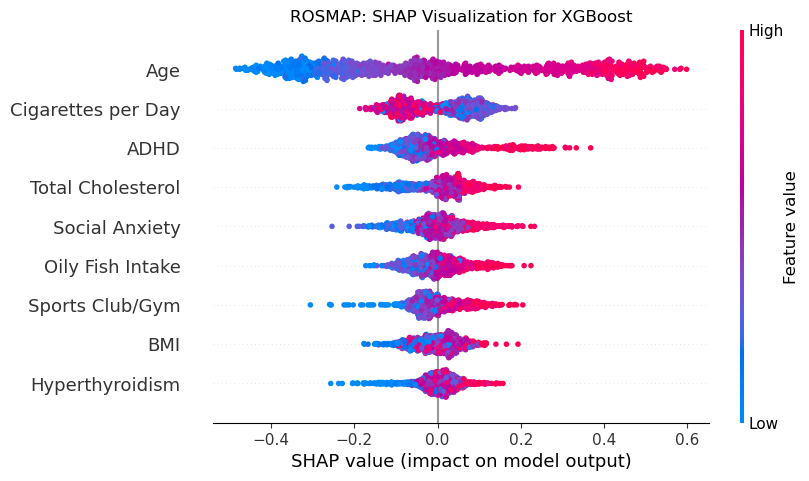

In [76]:
# explainer = shap.TreeExplainer(exported_pipeline)
# shap_values = explainer.shap_values(shuffled_X)

# shap.force_plot(explainer.expected_value, shap_values[0,:], shuffled_X.iloc[0,:])

print( np.array(SHAP_values_per_fold).shape )
shap.summary_plot(np.array(SHAP_values_per_fold), shuffled_X,  show=False)
plt.title("ROSMAP: SHAP Visualization for XGBoost", fontsize = 12)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
# plt.show()
plt.savefig("rosmap_shap.png",dpi=600)

In [62]:
print(shap_values)
print( shuffled_X.shape )
# shap.summary_plot(shap_values, shuffled_X)

[[ 1.47275009e-01  1.10614058e-02  1.03373599e-01  3.18765676e-02
  -2.77992219e-02  4.25483998e-03 -4.69635077e-02  1.02146842e-01
   2.21640396e-02]
 [ 2.33853643e-01  4.18814011e-02  3.37631727e-02 -8.10535901e-04
   3.16796764e-02  5.92823238e-02 -4.25893931e-03  7.07616898e-02
  -5.89138495e-02]
 [-1.55859446e-01  7.40619389e-02  2.42068486e-02 -4.63295127e-02
   5.01022003e-02 -6.60079247e-02 -1.76566087e-01  1.03669963e-01
  -2.17953080e-02]
 [ 6.94162337e-02  5.93198379e-02 -7.19587293e-02  9.92130662e-02
   3.02932834e-02 -5.67603711e-03 -2.43314089e-02  1.30627848e-01
   4.57568339e-02]
 [-3.06586829e-01  1.73557190e-02  1.32535145e-01 -2.08699010e-02
  -4.10339670e-02 -3.89827128e-02  1.64473412e-02  7.11513507e-02
  -8.41295829e-02]
 [ 4.81904485e-02  2.03794779e-02 -8.32161526e-02  2.34580077e-02
  -1.21368118e-03  1.30266554e-01 -2.65227491e-02 -1.60698578e-01
   1.10161107e-02]
 [-4.91605201e-02  8.42735920e-03 -9.23420181e-02  3.77397651e-02
   1.12006195e-03 -1.6936906

# SVM

In [63]:
# X_train, X_test, y_train, y_test = train_test_split(shuffled_X, shuffled_Y, test_size=0.25, random_state=0)

# Preprocess the data
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

# Create an SVM object
from sklearn.svm import SVC
classifier = SVC(kernel='linear', random_state=random_seed, probability=True)


accuracies=[]
precisions=[]
recalls=[]
fscores=[]
aurocs=[]
auprcs=[]
for train_index , test_index in kf.split(shuffled):
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
   
    # Train the model
    classifier.fit(X_train, y_train)

    # Evaluate the model
    y_pred = classifier.predict(X_test)
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
#     print(cm)

    true=y_test
    pred_binary=y_pred
    pred=classifier.predict_proba(X_test).T
    pred=pred[1]
    acc,precision, recall,fscore, auroc, auprc=GetScores(true,pred_binary,pred)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    aurocs.append(auroc)
    auprcs.append(auprc)
avg_acc=np.mean(accuracies)
avg_prec=np.mean(precisions)
avg_rec=np.mean(recalls)
avg_fsc=np.mean(fscores)
avg_roc=np.mean(aurocs)
avg_prc=np.mean(auprcs)
printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc)
if progression == "":
    write_out_to_csv("ROSMAP", "SVM", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)

(108,) (108,) (108,)
(108,) (108,) (108,)
(108,) (108,) (108,)
(108,) (108,) (108,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
accuracy: 0.6526220145379023
precision: 0.6566635996616756
recall: 0.6557661864840589
fscore: 0.6512868203344493
auroc: 0.7290314520656412
auprc: 0.7453815417506672
Average scores have been appended to the CSV file.


In [64]:

# shap.summary_plot(shap_values, training_features, plot_type="bar")

In [65]:
# SVM

# Random Forest Classifier

In [66]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=random_seed)
accuracies=[]
precisions=[]
recalls=[]
fscores=[]
aurocs=[]
auprcs=[]
for train_index , test_index in kf.split(shuffled):
    X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
    y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
    rfc.fit(X_train, y_train)
    y_pred_bin = rfc.predict(X_test)
    y_pred_frac= rfc.predict_proba(X_test).T[1]
    acc,precision, recall,fscore, auroc, auprc=GetScores(y_test,y_pred_bin,y_pred_frac)
    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    aurocs.append(auroc)
    auprcs.append(auprc)
avg_acc=np.mean(accuracies)
avg_prec=np.mean(precisions)
avg_rec=np.mean(recalls)
avg_fsc=np.mean(fscores)
avg_roc=np.mean(aurocs)
avg_prc=np.mean(auprcs)
printScores(avg_acc,avg_prec,avg_rec,avg_fsc,avg_roc,avg_prc)
if progression == "":
    write_out_to_csv("ROSMAP", "RF", yrs, avg_acc, avg_prec, avg_rec, avg_fsc, avg_roc, avg_prc)

(108,) (108,) (108,)
(108,) (108,) (108,)
(108,) (108,) (108,)
(108,) (108,) (108,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
(107,) (107,) (107,)
accuracy: 0.6610418830044998
precision: 0.6785554179184108
recall: 0.6235064348415122
fscore: 0.6595455595839863
auroc: 0.7096967892482688
auprc: 0.7109959472775429
Average scores have been appended to the CSV file.
